## NEARC 2019
> This notebook illustrates some of the concepts [I presented at Fall NEARC 2019](https://github.com/seansweeney/NEARC-2019). It does not alter any user data or otherwise run the script `move_agol_user_to_sso.py`.  

Before we get started, import some useful modules:

In [ ]:
from collections import Counter

### Three ways to connect to AGOL with the API for Python
#### Using AGOL logins

In [ ]:
username = input('Connection username: ')
password = getpass(prompt='Connection password: ')
 
# Connect to ArcGIS Online
try:
    # If your user belongs to more than one organization:
    org_url = "https://cambridgegis.maps.arcgis.com/"
    gis = GIS(org_url, username, password)
    
    # Otherwise can just connect to AGOL - org is automatic
    gis = GIS("https://arcgis.com/", username, password)
    
    # In fact the method defaults to AGOL so you don't even need to specify
    gis = GIS(username=username,password=password)
except:
    print(sys.exc_info()[0])
    exit(1)

#### Using enterprise logins
Get a client_id using by following the instructions here: [User authentication with OAuth 2.0](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/#User-authentication-with-OAuth-2.0)

In [ ]:
gis = GIS("https://cambridgegis.maps.arcgis.com/", client_id=client_id)

#### From ArcGIS Notebooks in AGOL
AGOL and the organization are implied by the current users's context, so connecting is simplified.  This probably works in Enterprise as well but I don't have it installed to test.

In [ ]:
from arcgis.gis import GIS
gis = GIS("home")

### The user object

In [ ]:
user = gis.users.get('ssweeney@cambridgema.gov_CambridgeGIS')

In [ ]:
user

#### Profile items for [user.update()](https://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#arcgis.gis.User.update)
Even though the documentation says that you can pass a URL to the thumbnail input on the update method, it doesn't seem to work to pass the _agol_user.get_thumbnail_link()_ result. Instead in my code I download the thumbnail and upload it to the new account, which seems to work. Here's how I did it in my code:
```python
agol_thumbnail_download = agol_user.download_thumbnail(os.getenv('TEMP'))

sso_user.update(access=agol_user.access, preferred_view=agol_user.preferredView, description=agol_user.description, tags=agol_user.tags, 
                thumbnail=agol_thumbnail_download, fullname=agol_user.fullName, culture=agol_user.culture, region=agol_user.region, 
                first_name=agol_user.firstName, last_name=agol_user.lastName)
```
The _User_ object properties referenced above will look something like this:

In [ ]:
print(user.access, user.preferredView, user.description, user.tags,
      user.get_thumbnail_link(), user.culture, user.region, 
      user.fullName, user.firstName, user.lastName, sep='\n')

#### All users
Here's a quick way to get a list of all user objects. I use this list for other things below.

In [ ]:
all_users = gis.users.search(None, max_users=500)

### Roles
For built-in user roles (*org_user, org_publisher, org_admin, viewer, view_only, viewplusedit*) you can just pass the role property to update_role.  

For custom roles you have to get the role object from the [RoleManager](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#rolemanager) static class (via gis.users.roles).  

You can't just use the second method for all users because the built-in roles don't exist in the RoleManager.
```python
builtin_roles = ['org_user', 'org_publisher', 'org_admin', 'viewer', 'view_only', 'viewplusedit']

if (agol_user.role in builtin_roles):
	# Built-in user role - assign directly
	sso_user.update_role(role=agol_user.role)
else:
	# Custom role - first get role object from RoleManager
	role = gis.users.roles.get_role(agol_user.roleId)
	sso_user.update_role(role=role)
```
You can get a feel for the roles used in your organization using something like the code below.

In [ ]:
builtin_roles = ['org_user', 'org_publisher', 'org_admin', 'viewer', 'view_only', 'viewplusedit']
builtins_used = {user.role for user in all_users if user.role == user.roleId and user.role in builtin_roles}
builtins_used

In [ ]:
# Get a list of custom roles for your organization
for role in gis.users.roles.all():
    print(role.name)

In [ ]:
# Get a usage count for each custom role
all_custom_roles = [gis.users.roles.get_role(user.roleId).name for user in all_users if user.role not in builtin_roles]
custom_roles_count = Counter(all_custom_roles)
custom_roles_count

### Regionalization
I assumed these settings would be the same for everyone in my organization, but there are some differences. I'm not sure why they don't all default to the same thing, though it may have to do with *when* a certain account was created.  I'm still trying to track down what None means in these contexts and what the difference between *en* and *en-US* is.

In [ ]:
units_used = {user.units for user in all_users}
units_used

In [ ]:
cultures_used = {user.culture for user in all_users}
cultures_used

In [ ]:
all_cultures = [user.culture for user in all_users]
Counter(all_cultures)

In [ ]:
culture_formats_used = {user.cultureFormat for user in all_users}
culture_formats_used

In [ ]:
all_culture_formats = [user.cultureFormat for user in all_users]
Counter(all_culture_formats)

### [Esri access](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html?highlight=esri_access#arcgis.gis.User.esri_access)
This is a weird one because the getter returns a string but the setter takes a Boolean. For us the return values are ```arcgisonly``` or ```both```. I can't find documentation on the valid values.  
You can find out all the values used in your instance using something like this:

In [ ]:
esri_access_used = {user.esri_access for user in all_users}
esri_access_used

### Groups
Groups are handled differently depending on whether the old user owns the group or not. If they do then you need to transfer the ownership. If they don't then they just join the group.

In [ ]:
for group in user.groups:
    if (group.owner == user.username):
        print(f'Owns: {group.title}')
    else:
        print(f'Member of: {group.title}')

### Content
#### item_reassign() function
Groups created with ```All items``` selected for ```What items in the group can its members update?``` will have items that can be updated. 

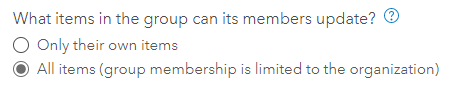

See 'Who can contribute content to the group?' in [Create a group](https://doc.arcgis.com/en/arcgis-online/share-maps/create-groups.htm#ESRI_SECTION1_946848D9B81D4607B3E3AB706EB267E3) for more details.

> For **Who can contribute content to the group?**, select one of the following:
> * **Group members**—All group members can contribute content to the group.
> * **Only group owner and managers**—Only you (the group owner), group managers, and administrators in the organization can contribute content to the group. If you choose this option, members can view and access your items, but they can't share their own items with the group. This type of group is a good way to share your authoritative maps and data to a targeted audience. You control what items appear in the group and who can view them.  

Items in groups with this setting cannot change ownership. If you try you'll get an error, whether in the UI:

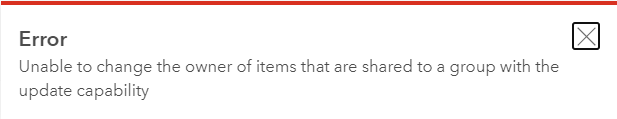

Or in Python:

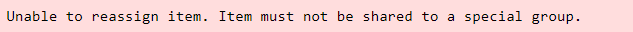

You can't find out from the ```Item``` itself whether it belongs to one of these groups, so what I've done is get a list of all such groups:

```python
all_groups = gis.groups.search('-')
update_groups = [group.title for group in all_groups if 'updateitemcontrol' in group.capabilities]
```

Then I created a function to reassign items, first checking if the item is in a protected group. If it is I remove it from the group, transfer it, then re-add it to the group.

```python
# Function to reassign items, taking into account "Share and update capabilities"
# See 'Who can contribute content to the group?' in https://doc.arcgis.com/en/arcgis-online/share-maps/create-groups.htm for more details
def item_reassign(item, user, folder=''):
    # Get a list of the item's groups
    item_groups = [group.title for group in item.shared_with['groups']]
    # See if any of them are restricted (configured to allow all members to update all items)
    item_update_groups = [title for title in item_groups if title in update_groups]
    # If so the item nees to be removed from those groups before it can be moved
    if item_update_groups:
        item.unshare(item_update_groups)
        
    try:
        # Do the move
        item.reassign_to(user, target_folder=folder)
    except Exception as e:
        print(e)
        raise e
    
    # Add the item back into the restricted groups (if applicable)
    if item_update_groups:
        item.share(groups=item_update_groups, allow_members_to_edit=True)
```
You find the protected groups by searching for the value *updateitemcontrol* in the *group.capabilities*, which is a list:

In [ ]:
all_groups = gis.groups.search()
update_groups = [group.title for group in all_groups if 'updateitemcontrol' in group.capabilities]
update_groups

In [ ]:
# And here's what happens when you try to transfer the ownership to an item in one of those groups
item = gis.content.get('445591ed69c342789df41dcb77927ce2')
item.reassign_to(target_owner=user.username, target_folder=None)

You can get a list of the groups an item belongs to then compare it against the list of known special groups to determine if the item needs to be unshared from the group before being transferred.  

In [ ]:
# Get a list of the item's groups
item_groups = [group.title for group in item.shared_with['groups']]
# See if any of them are restricted (configured to allow all members to update all items)
item_update_groups = [title for title in item_groups if title in update_groups]
# Note you could also use a set operator to get the same result, but I *think* the list comprehension is faster than convert(convert,convert)
# item_update_groups = list(set(item_groups) & set(update_groups))
item_update_groups

#### Root items
You can get the list of root items directly from [User.items](https://developers.arcgis.com/python/api-reference/arcgis.gis.toc.html#arcgis.gis.User.items) with no arguments (`Folder=None` is the default):
```python
agol_root_items = agol_user.items()
print('Folder: Root')
for item in agol_root_items:
    try:
        print('* Moving: ' + item.title)
        item_reassign(item=item, user=sso_username, folder=None)
    except Exception as e:
        print(e)
        print("Item may have already been assigned to user.")
```

In [ ]:
user.items()

#### Folder items
Folder items are a little trickier. First, we need to create the new folder on for the target user (if it doesn't already exist). Then we can retrieve the folder items using either the folder name (as shown below) or the folder's unique ID (not shown). Once we have the list we can loop through the items and move them the same way we did for the root items.
```python
agol_folders = agol_user.folders
sso_folders = sso_user.folders
sso_foldernames = [folder['title'] for folder in sso_folders]
for agol_folder in agol_folders:
    print('Folder: ' + agol_folder['title'])
    # In case script needs to be run twice for some reason, make sure the folder 
    # doesn't already exist before creating it
    if agol_folder['title'] not in sso_foldernames: 
        gis.content.create_folder(agol_folder['title'], sso_username)
    # Get a list of items from the source folder, then loop through and move each item
    agol_folder_items = agol_user.items(folder=agol_folder['title']) 
    for item in agol_folder_items:
        print('* Moving ' + item.title)
        try:
            item_reassign(item=item, user=sso_username, folder=agol_folder['title'])
        except Exception as e:
            print(e)
            print("Unable to reassign item " + item.title + " to folder " + agol_folder['title'])
```

In [ ]:
folders = user.folders # list of folder objects
foldernames = [folder['title'] for folder in folders]
foldernames

### Things we can't do (yet)
#### Favorites and licenses
You can get the favorites and licenses from the UI but I couldn't figure out a way to set them. I had the script dump out a list of each so they could be re-set manually on the new user (if desired).

In [ ]:
fav_items = gis.groups.get(user.favGroupId)
favs = [content.title for content in fav_items.content()]
if favs:
    print(favs)

#### Credits
This is supposed to work according to the API documentation and the ArcGIS Notebooks Online samples, but it doesn't actually work for me.  
See [CreditManager](https://developers.arcgis.com/python/api-reference/arcgis.gis.admin.html?#creditmanager) for more details.

In [ ]:
print(f'User has {user.assignedCredits} credits assigned and {user.availableCredits} available')
gis.admin.credits.allocate(username=user.username, credits=200)
print(f'User has {user.assignedCredits} credits assigned and {user.availableCredits} available')

#### Link your ArcGIS accounts
Requires authentication to the other account(s), so it has to be done by the user after the fact.